In [1]:
import numpy as np
import pandas as pd
import itertools, os
import seaborn as sns
import networkx as nx
from tqdm import tqdm
import multiprocess as mp
import matplotlib.pyplot as plt
from homophily_model import HomophilyModel

sns.set(style="whitegrid", font_scale=1.6)
plt.style.use('paper.mplstyle.txt')

In [2]:
def run_model(pars):
    from homophily_model import HomophilyModel
    min_frac = pars['min_frac']
    homophily = pars['homophily']
    shuffle_agents = pars['model_type'][1]
    pairwise = pars['model_type'][0]
    model = HomophilyModel(n=200, d=1.0, v=1.0, L=100, 
                           balance=min_frac, h_ii=homophily,
                           shuffle_agents=shuffle_agents,
                           pairwise=pairwise)
    model.run(number_of_iterations=1000, verbose=False)
    type_degree = [[min_frac, homophily, pars['model_type'], 
                    model.t[node], len(interactions)] for \
                   node, interactions in model.nx_edges.items()]
    return type_degree

In [3]:
run_model({'min_frac': 0.1, 'homophily': 0.2, 'model_type':('pairwise','shuffled')})

[[0.1, 0.2, ('pairwise', 'shuffled'), 1, 1],
 [0.1, 0.2, ('pairwise', 'shuffled'), 1, 43],
 [0.1, 0.2, ('pairwise', 'shuffled'), 0, 12],
 [0.1, 0.2, ('pairwise', 'shuffled'), 1, 38],
 [0.1, 0.2, ('pairwise', 'shuffled'), 1, 18],
 [0.1, 0.2, ('pairwise', 'shuffled'), 1, 5],
 [0.1, 0.2, ('pairwise', 'shuffled'), 1, 4],
 [0.1, 0.2, ('pairwise', 'shuffled'), 1, 18],
 [0.1, 0.2, ('pairwise', 'shuffled'), 1, 55],
 [0.1, 0.2, ('pairwise', 'shuffled'), 0, 26],
 [0.1, 0.2, ('pairwise', 'shuffled'), 1, 7],
 [0.1, 0.2, ('pairwise', 'shuffled'), 1, 5],
 [0.1, 0.2, ('pairwise', 'shuffled'), 1, 3],
 [0.1, 0.2, ('pairwise', 'shuffled'), 1, 9],
 [0.1, 0.2, ('pairwise', 'shuffled'), 1, 1],
 [0.1, 0.2, ('pairwise', 'shuffled'), 1, 28],
 [0.1, 0.2, ('pairwise', 'shuffled'), 1, 1],
 [0.1, 0.2, ('pairwise', 'shuffled'), 1, 21],
 [0.1, 0.2, ('pairwise', 'shuffled'), 1, 3],
 [0.1, 0.2, ('pairwise', 'shuffled'), 1, 17],
 [0.1, 0.2, ('pairwise', 'shuffled'), 1, 11],
 [0.1, 0.2, ('pairwise', 'shuffled'), 1, 5],

In [4]:
model = HomophilyModel()
model.run(number_of_iterations=1000, verbose=False)

In [5]:
G = nx.from_dict_of_lists(model.nx_edges)
nx.set_node_attributes(G, dict(zip(range(len(model.t)), model.t.astype(str))), name="Minority")
interactions = {str(node):val for node, val in G.degree()}
nx.set_node_attributes(G, interactions)

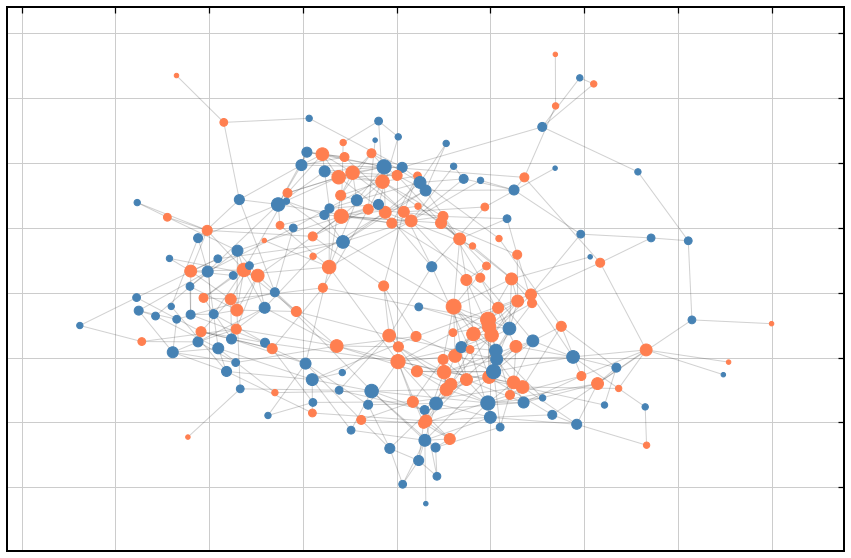

In [6]:
nodes = G.nodes()
colors = ['coral' if int(G.nodes[n]['Minority']) else 'steelblue' for n in nodes]

# drawing nodes and edges separately so we can capture collection for colobar
plt.figure(figsize=(15,10)) 
pos = nx.spring_layout(G)
ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=colors, 
                            label=False, node_size=[20*val for node, val in G.degree()])
plt.show()

In [26]:
# Create combinations
reps = 50
fracs = [0.1, 0.2, 0.3, 0.4, 0.5]
homophilies = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
model_types = [('not-shuffled', 'all-highest-h_ii'),
               ('shuffled', 'all-highest-h_ii'),
               ('shuffled', 'pairwise')]

In [27]:
combinations = list(itertools.product(*[fracs, homophilies, model_types]))

par_values = []
for rep in range(reps):
    for frac, homophily, model_type in combinations:
        params = {}
        params['min_frac'] = frac
        params['homophily'] = homophily
        params['model_type'] = model_type
        par_values += [params]
print(len(par_values), par_values[0])

6750 {'min_frac': 0.1, 'homophily': 0.1, 'model_type': ('not-shuffled', 'all-highest-h_ii')}


In [28]:
n_cpus = os.cpu_count()
p = mp.Pool(n_cpus)
res = p.imap_unordered(run_model, par_values, chunksize=20)#len(par_values)//n_cpus)
results = []
for r in tqdm(res, total=len(par_values), position=0, leave=True):
    results += r

100%|███████████████████████████████████████████████████████████████████████████████| 6750/6750 [12:31<00:00,  8.99it/s]


In [29]:
cols = ['Minority fraction', 'Homophily', 'Model type', 'Type', 'Degree']
data = pd.DataFrame(results, columns=cols)

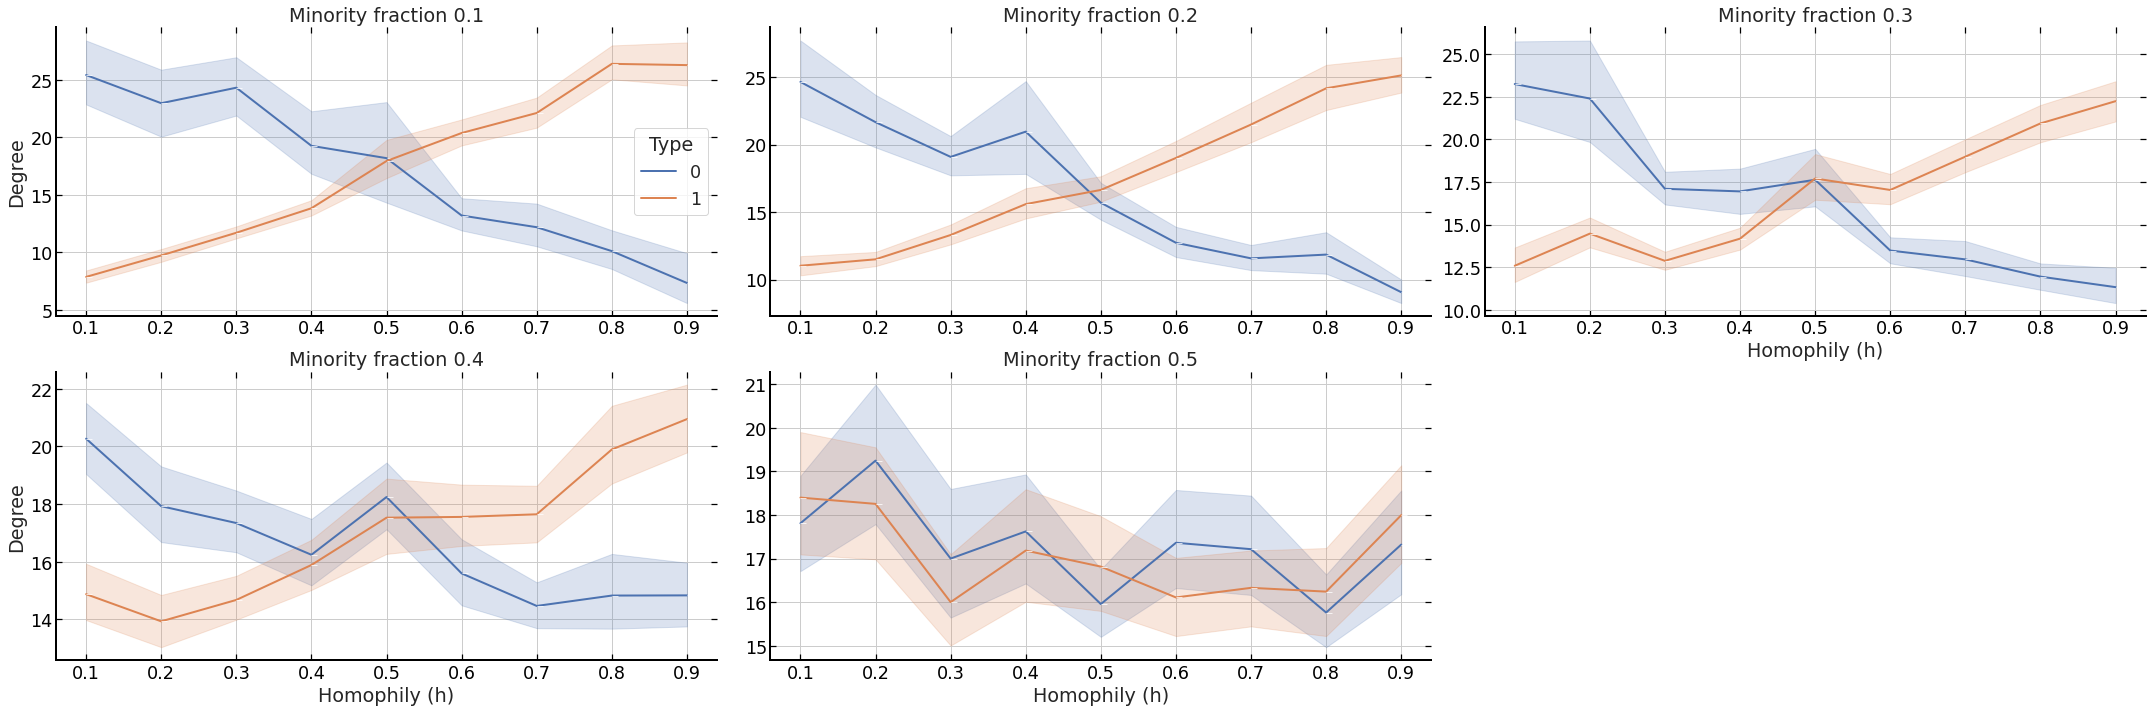

In [34]:
g = sns.relplot(
    data=data[data['Model type']==('not-shuffled', 'all-highest-h_ii')], x="Homophily", y="Degree", 
    col='Minority fraction', hue='Type',
    marker=True, facet_kws={'sharey':False, 'sharex':False, 'legend_out':False},
    kind="line", col_wrap=3, height=5, aspect=2,
)
g.set_axis_labels("Homophily (h)", "Degree")
g.set_titles("{col_var} {col_name}")

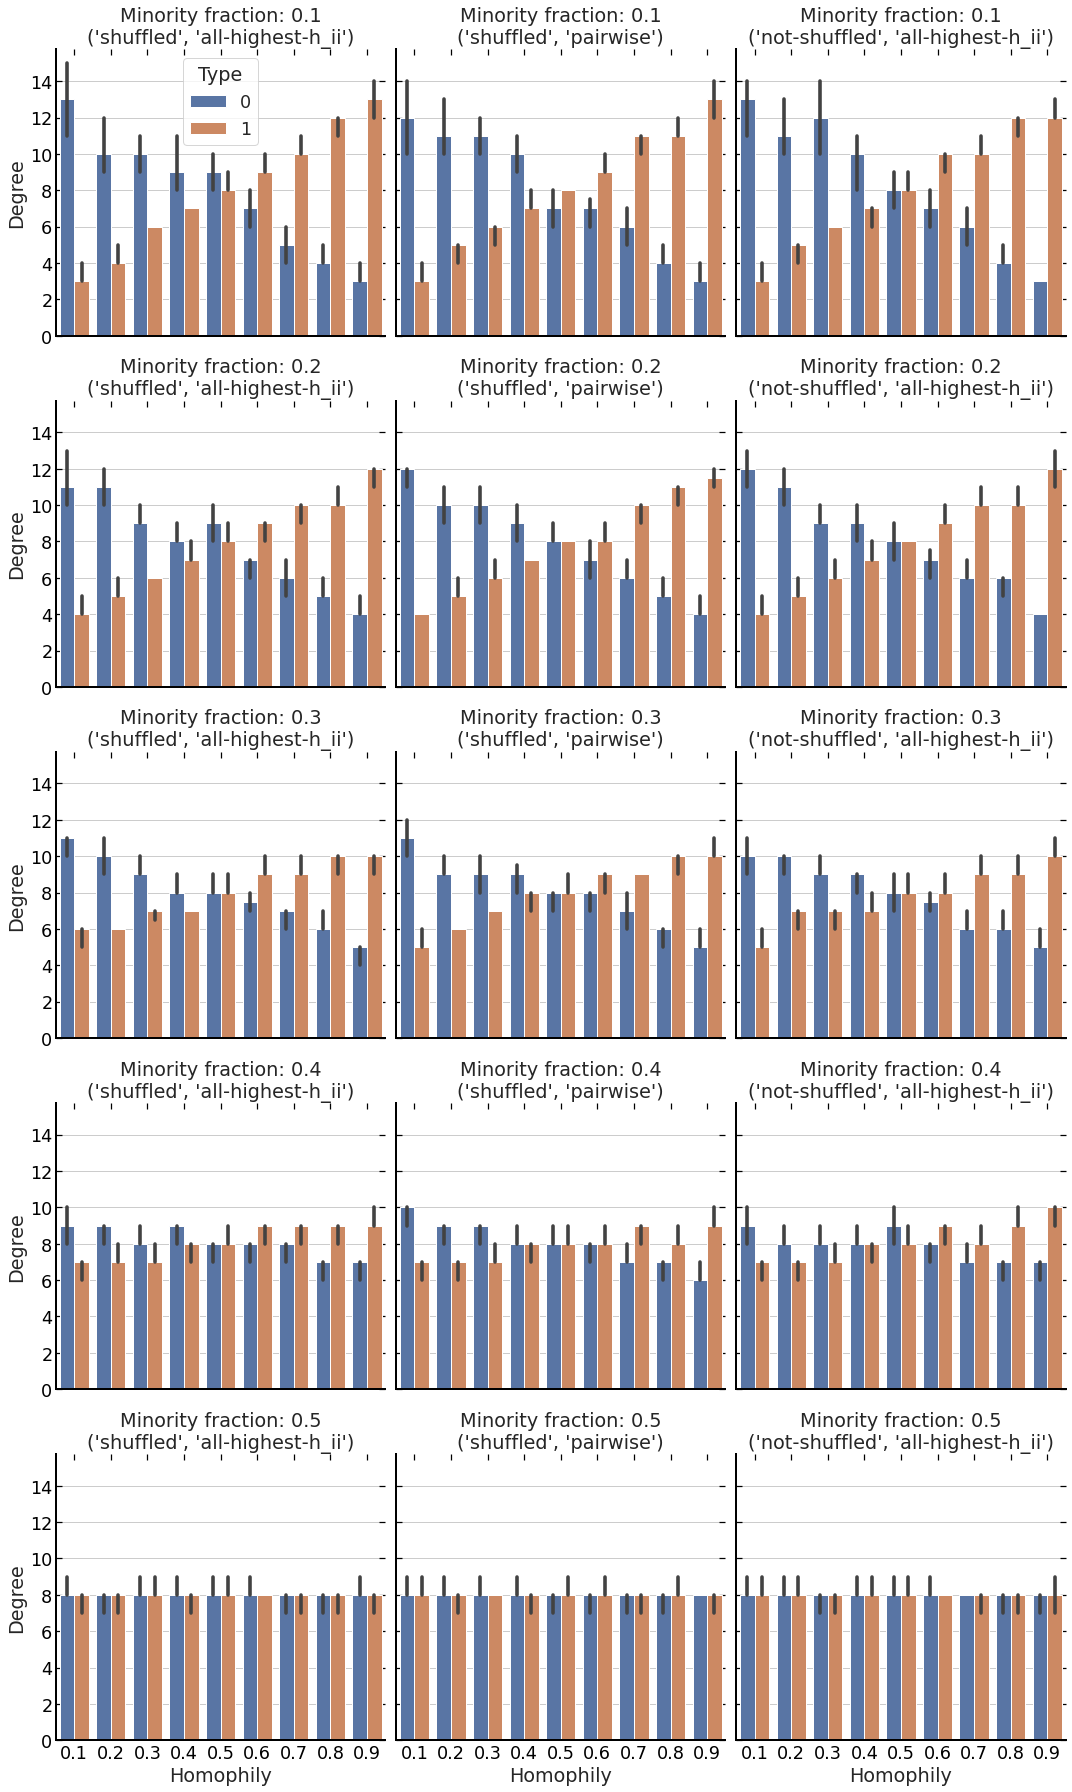

In [39]:
g = sns.catplot(
    data=data, x="Homophily", y="Degree", hue="Type",
    row='Minority fraction', col='Model type',
    kind="bar", estimator=np.median, ci=99,
    legend_out=False
)
g.set_titles("Minority fraction: {row_name}\n{col_name}")
plt.tight_layout()